In [1]:
import torch
from torch import nn
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import optim
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import gc
import math

In [2]:
#Params
input_size=500
batch_size=512
nbr_epochs=400
data_split_ratio=0.8
chunksize = 100000
lr = 0.00005
y_column = "300s"
files_x = ["data/x_Swedbank_A_750_p.csv",]
files_y = ["data/y_Swedbank_A_750.csv",]

In [3]:
def splitData(xs, ys, trainRatio):
    t = round(len(xs)*trainRatio)
    
    train_data_x = torch.tensor(xs[:t].values, dtype=torch.float32)
    train_data_y = torch.tensor(ys[:t].values, dtype=torch.float32)
    
    dev_data_x = torch.tensor(xs[t:].values, dtype=torch.float32)
    dev_data_y = torch.tensor(ys[t:].values, dtype=torch.float32)
    
    return TensorDataset(train_data_x, train_data_y), TensorDataset(dev_data_x, dev_data_y)

In [4]:
#compute_unit = "cuda:0" if torch.cuda.is_available() else "cpu"
device = torch.device('cuda:0')
#device = torch.device("cpu")
#compute_unit = "cpu"

In [5]:
#dtype = torch.FloatTensor
dtype = torch.cuda.FloatTensor # Uncomment this to run on GPU

In [6]:
class StockModel(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 1000).type(dtype)
        nn.init.normal(self.fc1.weight, mean=0, std=1)
        self.fc1.weight = nn.Parameter(self.fc1.weight * math.sqrt(2/input_size))
        self.fc2 = nn.Linear(1000, 2000).type(dtype)
        nn.init.normal(self.fc2.weight, mean=0, std=1)
        self.fc2.weight = nn.Parameter(self.fc2.weight * math.sqrt(2/input_size))
        self.fc3 = nn.Linear(2000, 1000).type(dtype)
        nn.init.normal(self.fc3.weight, mean=0, std=1)
        self.fc3.weight = nn.Parameter(self.fc3.weight * math.sqrt(2/input_size))
        self.fc4 = nn.Linear(1000, 500).type(dtype)
        nn.init.normal(self.fc4.weight, mean=0, std=1)
        self.fc4.weight = nn.Parameter(self.fc4.weight * math.sqrt(2/input_size))
        self.fc5 = nn.Linear(500, 100).type(dtype)
        nn.init.normal(self.fc5.weight, mean=0, std=1)
        self.fc5.weight = nn.Parameter(self.fc5.weight * math.sqrt(2/input_size))
        self.fc6 = nn.Linear(100, 20).type(dtype)
        nn.init.normal(self.fc6.weight, mean=0, std=1)
        self.fc6.weight = nn.Parameter(self.fc6.weight * math.sqrt(2/input_size))
        self.fc7 = nn.Linear(20, 1).type(dtype)
        nn.init.normal(self.fc7.weight, mean=0, std=1)
        self.fc7.weight = nn.Parameter(self.fc7.weight * math.sqrt(2/input_size))
        
        self.drop_layer = nn.Dropout(p=0.010)
    
    def forward(self, x):
        #print(x)
        fc1 = self.fc1(x)
        x = F.relu(fc1)
        #x = self.drop_layer(x)
        #print(fc1)
        #print(x)
        x = F.relu(self.fc2(x))
        #x = self.drop_layer(x)
        #print(x)
        x = F.relu(self.fc3(x))
        #x = self.drop_layer(x)
        #x = self.drop_layer(x)
        #print(x)
        x= F.relu(self.fc4(x))
        #print(y)
        x = F.relu(self.fc5(x))
        #x = self.drop_layer(x)
        x = F.relu(self.fc6(x))
        y = F.relu(self.fc7(x))
        return y

In [7]:
def evaluate_model(data, model, loss_fn):
    losses = []
    predictions = []
    model.eval()
    with torch.no_grad():
        for x, y in data:
            y = y.type(dtype)
            x = x.type(dtype)
            pred = model(x)
            loss = loss_fn(pred, y)
            losses.append(loss.item())
            predictions.extend(pred.tolist())
        avg_loss = sum(losses)/len(losses)    
    
    return avg_loss, predictions

In [8]:
def train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, epochrange, batchsize):
    for epoch in range(epochrange):
        losses = []
        n_correct = 0
        model.train()
        for x, y in train_data_loader:
            y = y.type(dtype)
            x = x.type(dtype)
            
            pred = model(x)

            loss = loss_fn(pred, y)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()    

        # Compute accuracy and loss in the entire training set
        train_avg_loss = sum(losses)/len(losses)    
        
        dev_avg_loss,_ = evaluate_model(dev_data_loader, model, loss_fn)
        
        # Display metrics
        display_str = 'Epoch {} '
        display_str += '\tLoss: {:.3f} '
        display_str += '\tLoss (val): {:.3f}'
        print(display_str.format(epoch, train_avg_loss, dev_avg_loss))

In [9]:
def train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size):
    train_data, dev_data = splitData(x_data, y_data, data_split_ratio)
    train_data_loader = DataLoader(train_data, batch_size=batch_size)
    dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)
    

In [10]:
#Start training
model = StockModel(input_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
model = model.to(device)
test_data_x = pd.DataFrame()
test_data_y = pd.DataFrame()
for i in range(len(files_x)):
    print("Current file: " + files_x[i])
    total_rows = sum(1 for row in open(files_x[i], 'r'))
    number_of_loops = int(total_rows/chunksize)
    print("Number of chunks: " + str(number_of_loops))
    current_loop = 0
    with pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)], chunksize=chunksize) as reader_x,\
    pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int}, chunksize=chunksize) as reader_y:
        for chunk_x, chunk_y in zip(reader_x, reader_y):
            print("Progress: " + "{:.2f}".format(100 * current_loop/number_of_loops) + "%")
            x_data = chunk_x
            y_data = chunk_y
            if(current_loop < data_split_ratio * number_of_loops):
                y_data = y_data[y_column]
                train_chunk(model, loss_fn, optimizer, nbr_epochs, x_data, y_data, data_split_ratio, batch_size)
            else:
                print("Append test data")
                test_data_x = test_data_x.append(x_data)
                test_data_y = test_data_y.append(y_data)
            current_loop+=1

test_data_x = torch.tensor(test_data_x.values, dtype=torch.float32)
test_data_y = torch.tensor(test_data_y[y_column].values, dtype=torch.float32)
test_data = TensorDataset(test_data_x, test_data_y)
#test_data_y = test_data_y[y_column]
#test_data = list(zip(test_data_x, test_data_y))
#for i in range(len(files_x)):
#    x_data = pd.read_csv(files_x[i], sep=";", dtype="float32", usecols = [j for j in range(input_size)])
#    y_data = pd.read_csv(files_y[i], sep=";", dtype="float32", converters = {'ts': int})
#    y_data = y_data[y_column]
#    print(x_data.shape)
#    print(y_data.shape)
#    x_data.head()
#    y_data.head()
#    print(files_x[i])
#    train_data, dev_data, test_data = splitData(x_data, y_data, data_split_ratio)
#    train_data_loader = DataLoader(train_data, batch_size=batch_size)
#    dev_data_loader = DataLoader(dev_data, batch_size=batch_size)
#    model = model.to(device)
#    train_model(model, train_data_loader, dev_data_loader, loss_fn, optimizer, nbr_epochs, batch_size)
#    del [[x_data, y_data, train_data, dev_data, train_data_loader, dev_data_loader]]
#    gc.collect()



/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  """
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  # This is added back by InteractiveShellApp.init_path()
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: nn.init.normal is now deprecated i

Current file: data/x_Swedbank_A_750_p.csv
Number of chunks: 31


/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/ipykernel_launcher.py:16: ParserWarning: Both a converter and dtype were specified for column ts - only the converter will be used
  app.launch_new_instance()


Progress: 0.00%


/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([512])) that is different to the input size (torch.Size([512, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([128])) that is different to the input size (torch.Size([128, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 1])). This will likely lead to incorrect results due to broadcasting. Plea

Epoch 0 	Loss: 135.889 	Loss (val): 7.259
Epoch 1 	Loss: 0.950 	Loss (val): 11.035
Epoch 2 	Loss: 0.704 	Loss (val): 4.426
Epoch 3 	Loss: 0.700 	Loss (val): 4.841
Epoch 4 	Loss: 0.695 	Loss (val): 0.596
Epoch 5 	Loss: 0.524 	Loss (val): 1.030
Epoch 6 	Loss: 0.472 	Loss (val): 4.133
Epoch 7 	Loss: 0.433 	Loss (val): 2.468
Epoch 8 	Loss: 0.415 	Loss (val): 1.448
Epoch 9 	Loss: 0.497 	Loss (val): 0.954
Epoch 10 	Loss: 0.513 	Loss (val): 4.932
Epoch 11 	Loss: 0.533 	Loss (val): 9.039
Epoch 12 	Loss: 0.663 	Loss (val): 10.986
Epoch 13 	Loss: 0.857 	Loss (val): 14.431
Epoch 14 	Loss: 0.981 	Loss (val): 13.346
Epoch 15 	Loss: 1.011 	Loss (val): 9.550
Epoch 16 	Loss: 0.914 	Loss (val): 5.945
Epoch 17 	Loss: 0.837 	Loss (val): 4.265
Epoch 18 	Loss: 0.847 	Loss (val): 4.354
Epoch 19 	Loss: 0.925 	Loss (val): 4.402
Epoch 20 	Loss: 0.949 	Loss (val): 4.304
Epoch 21 	Loss: 0.939 	Loss (val): 4.214
Epoch 22 	Loss: 0.898 	Loss (val): 3.826
Epoch 23 	Loss: 0.876 	Loss (val): 3.262
Epoch 24 	Loss: 0.85

Epoch 198 	Loss: 0.567 	Loss (val): 5.479
Epoch 199 	Loss: 0.566 	Loss (val): 4.956
Epoch 200 	Loss: 0.622 	Loss (val): 6.287
Epoch 201 	Loss: 0.591 	Loss (val): 6.034
Epoch 202 	Loss: 0.579 	Loss (val): 5.720
Epoch 203 	Loss: 0.568 	Loss (val): 5.461
Epoch 204 	Loss: 0.562 	Loss (val): 5.235
Epoch 205 	Loss: 0.605 	Loss (val): 6.284
Epoch 206 	Loss: 0.580 	Loss (val): 5.608
Epoch 207 	Loss: 0.563 	Loss (val): 5.479
Epoch 208 	Loss: 0.563 	Loss (val): 5.387
Epoch 209 	Loss: 0.560 	Loss (val): 5.164
Epoch 210 	Loss: 0.556 	Loss (val): 5.093
Epoch 211 	Loss: 0.555 	Loss (val): 5.055
Epoch 212 	Loss: 0.620 	Loss (val): 3.882
Epoch 213 	Loss: 0.633 	Loss (val): 5.626
Epoch 214 	Loss: 0.562 	Loss (val): 5.081
Epoch 215 	Loss: 0.552 	Loss (val): 4.689
Epoch 216 	Loss: 0.547 	Loss (val): 5.526
Epoch 217 	Loss: 0.558 	Loss (val): 5.075
Epoch 218 	Loss: 0.551 	Loss (val): 4.859
Epoch 219 	Loss: 0.546 	Loss (val): 4.658
Epoch 220 	Loss: 0.541 	Loss (val): 4.616
Epoch 221 	Loss: 0.545 	Loss (val)

Epoch 393 	Loss: 0.791 	Loss (val): 5.550
Epoch 394 	Loss: 0.834 	Loss (val): 4.771
Epoch 395 	Loss: 0.782 	Loss (val): 5.611
Epoch 396 	Loss: 0.782 	Loss (val): 5.902
Epoch 397 	Loss: 0.780 	Loss (val): 6.440
Epoch 398 	Loss: 0.880 	Loss (val): 3.843
Epoch 399 	Loss: 0.840 	Loss (val): 4.182
Progress: 3.23%
Epoch 0 	Loss: 0.625 	Loss (val): 0.239
Epoch 1 	Loss: 0.503 	Loss (val): 0.249
Epoch 2 	Loss: 0.508 	Loss (val): 0.244
Epoch 3 	Loss: 0.506 	Loss (val): 0.237
Epoch 4 	Loss: 0.500 	Loss (val): 0.232
Epoch 5 	Loss: 0.494 	Loss (val): 0.230
Epoch 6 	Loss: 0.486 	Loss (val): 0.229
Epoch 7 	Loss: 0.475 	Loss (val): 0.230
Epoch 8 	Loss: 0.467 	Loss (val): 0.232
Epoch 9 	Loss: 0.453 	Loss (val): 0.236
Epoch 10 	Loss: 0.446 	Loss (val): 0.243
Epoch 11 	Loss: 0.420 	Loss (val): 0.297
Epoch 12 	Loss: 0.413 	Loss (val): 0.284
Epoch 13 	Loss: 0.412 	Loss (val): 0.291
Epoch 14 	Loss: 0.407 	Loss (val): 0.300
Epoch 15 	Loss: 0.390 	Loss (val): 0.319
Epoch 16 	Loss: 0.392 	Loss (val): 0.324
Epo

Epoch 191 	Loss: 0.505 	Loss (val): 0.247
Epoch 192 	Loss: 0.510 	Loss (val): 0.250
Epoch 193 	Loss: 0.512 	Loss (val): 0.262
Epoch 194 	Loss: 0.516 	Loss (val): 0.270
Epoch 195 	Loss: 0.507 	Loss (val): 0.244
Epoch 196 	Loss: 0.508 	Loss (val): 0.264
Epoch 197 	Loss: 0.520 	Loss (val): 0.271
Epoch 198 	Loss: 0.521 	Loss (val): 0.268
Epoch 199 	Loss: 0.522 	Loss (val): 0.255
Epoch 200 	Loss: 0.514 	Loss (val): 0.284
Epoch 201 	Loss: 0.525 	Loss (val): 0.291
Epoch 202 	Loss: 0.529 	Loss (val): 0.303
Epoch 203 	Loss: 0.534 	Loss (val): 0.306
Epoch 204 	Loss: 0.535 	Loss (val): 0.315
Epoch 205 	Loss: 0.503 	Loss (val): 0.249
Epoch 206 	Loss: 0.455 	Loss (val): 0.277
Epoch 207 	Loss: 0.523 	Loss (val): 0.297
Epoch 208 	Loss: 0.531 	Loss (val): 0.308
Epoch 209 	Loss: 0.537 	Loss (val): 0.317
Epoch 210 	Loss: 0.543 	Loss (val): 0.324
Epoch 211 	Loss: 0.549 	Loss (val): 0.330
Epoch 212 	Loss: 0.556 	Loss (val): 0.335
Epoch 213 	Loss: 0.562 	Loss (val): 0.338
Epoch 214 	Loss: 0.568 	Loss (val)

Epoch 387 	Loss: 1.274 	Loss (val): 0.462
Epoch 388 	Loss: 1.272 	Loss (val): 0.464
Epoch 389 	Loss: 1.270 	Loss (val): 0.325
Epoch 390 	Loss: 1.314 	Loss (val): 0.417
Epoch 391 	Loss: 1.299 	Loss (val): 0.440
Epoch 392 	Loss: 1.267 	Loss (val): 0.348
Epoch 393 	Loss: 1.289 	Loss (val): 0.456
Epoch 394 	Loss: 1.274 	Loss (val): 0.448
Epoch 395 	Loss: 1.272 	Loss (val): 0.461
Epoch 396 	Loss: 1.267 	Loss (val): 0.460
Epoch 397 	Loss: 1.265 	Loss (val): 0.440
Epoch 398 	Loss: 1.272 	Loss (val): 0.469
Epoch 399 	Loss: 1.265 	Loss (val): 0.471
Progress: 6.45%
Epoch 0 	Loss: 0.378 	Loss (val): 0.135
Epoch 1 	Loss: 0.341 	Loss (val): 0.143
Epoch 2 	Loss: 0.352 	Loss (val): 0.161
Epoch 3 	Loss: 0.368 	Loss (val): 0.170
Epoch 4 	Loss: 0.388 	Loss (val): 0.165
Epoch 5 	Loss: 0.410 	Loss (val): 0.150
Epoch 6 	Loss: 0.429 	Loss (val): 0.137
Epoch 7 	Loss: 0.444 	Loss (val): 0.136
Epoch 8 	Loss: 0.454 	Loss (val): 0.153
Epoch 9 	Loss: 0.462 	Loss (val): 0.181
Epoch 10 	Loss: 0.472 	Loss (val): 0.2

Epoch 185 	Loss: 0.486 	Loss (val): 0.279
Epoch 186 	Loss: 0.484 	Loss (val): 0.322
Epoch 187 	Loss: 0.492 	Loss (val): 0.289
Epoch 188 	Loss: 0.489 	Loss (val): 0.287
Epoch 189 	Loss: 0.486 	Loss (val): 0.277
Epoch 190 	Loss: 0.485 	Loss (val): 0.273
Epoch 191 	Loss: 0.484 	Loss (val): 0.271
Epoch 192 	Loss: 0.484 	Loss (val): 0.270
Epoch 193 	Loss: 0.483 	Loss (val): 0.283
Epoch 194 	Loss: 0.484 	Loss (val): 0.274
Epoch 195 	Loss: 0.485 	Loss (val): 0.271
Epoch 196 	Loss: 0.483 	Loss (val): 0.293
Epoch 197 	Loss: 0.482 	Loss (val): 0.265
Epoch 198 	Loss: 0.482 	Loss (val): 0.275
Epoch 199 	Loss: 0.486 	Loss (val): 0.269
Epoch 200 	Loss: 0.483 	Loss (val): 0.265
Epoch 201 	Loss: 0.482 	Loss (val): 0.263
Epoch 202 	Loss: 0.482 	Loss (val): 0.261
Epoch 203 	Loss: 0.481 	Loss (val): 0.261
Epoch 204 	Loss: 0.481 	Loss (val): 0.273
Epoch 205 	Loss: 0.482 	Loss (val): 0.263
Epoch 206 	Loss: 0.481 	Loss (val): 0.257
Epoch 207 	Loss: 0.481 	Loss (val): 0.256
Epoch 208 	Loss: 0.480 	Loss (val)

Epoch 381 	Loss: 0.467 	Loss (val): 0.197
Epoch 382 	Loss: 0.469 	Loss (val): 0.196
Epoch 383 	Loss: 0.465 	Loss (val): 0.191
Epoch 384 	Loss: 0.465 	Loss (val): 0.189
Epoch 385 	Loss: 0.464 	Loss (val): 0.188
Epoch 386 	Loss: 0.464 	Loss (val): 0.186
Epoch 387 	Loss: 0.464 	Loss (val): 0.185
Epoch 388 	Loss: 0.464 	Loss (val): 0.185
Epoch 389 	Loss: 0.463 	Loss (val): 0.184
Epoch 390 	Loss: 0.463 	Loss (val): 0.183
Epoch 391 	Loss: 0.463 	Loss (val): 0.182
Epoch 392 	Loss: 0.464 	Loss (val): 0.181
Epoch 393 	Loss: 0.463 	Loss (val): 0.180
Epoch 394 	Loss: 0.462 	Loss (val): 0.179
Epoch 395 	Loss: 0.462 	Loss (val): 0.179
Epoch 396 	Loss: 0.462 	Loss (val): 0.178
Epoch 397 	Loss: 0.463 	Loss (val): 0.177
Epoch 398 	Loss: 0.462 	Loss (val): 0.176
Epoch 399 	Loss: 0.462 	Loss (val): 0.176
Progress: 9.68%
Epoch 0 	Loss: 0.418 	Loss (val): 0.386
Epoch 1 	Loss: 0.420 	Loss (val): 0.389
Epoch 2 	Loss: 0.415 	Loss (val): 0.393
Epoch 3 	Loss: 0.416 	Loss (val): 0.396
Epoch 4 	Loss: 0.415 	Loss

Epoch 179 	Loss: 0.682 	Loss (val): 0.277
Epoch 180 	Loss: 0.682 	Loss (val): 0.277
Epoch 181 	Loss: 0.682 	Loss (val): 0.277
Epoch 182 	Loss: 0.678 	Loss (val): 0.277
Epoch 183 	Loss: 0.682 	Loss (val): 0.277
Epoch 184 	Loss: 0.681 	Loss (val): 0.277
Epoch 185 	Loss: 0.681 	Loss (val): 0.276
Epoch 186 	Loss: 0.681 	Loss (val): 0.277
Epoch 187 	Loss: 0.680 	Loss (val): 0.277
Epoch 188 	Loss: 0.681 	Loss (val): 0.277
Epoch 189 	Loss: 0.681 	Loss (val): 0.277
Epoch 190 	Loss: 0.682 	Loss (val): 0.277
Epoch 191 	Loss: 0.682 	Loss (val): 0.277
Epoch 192 	Loss: 0.682 	Loss (val): 0.276
Epoch 193 	Loss: 0.682 	Loss (val): 0.276
Epoch 194 	Loss: 0.681 	Loss (val): 0.276
Epoch 195 	Loss: 0.652 	Loss (val): 0.276
Epoch 196 	Loss: 0.682 	Loss (val): 0.277
Epoch 197 	Loss: 0.682 	Loss (val): 0.276
Epoch 198 	Loss: 0.682 	Loss (val): 0.276
Epoch 199 	Loss: 0.683 	Loss (val): 0.276
Epoch 200 	Loss: 0.682 	Loss (val): 0.275
Epoch 201 	Loss: 0.682 	Loss (val): 0.275
Epoch 202 	Loss: 0.682 	Loss (val)

Epoch 375 	Loss: 0.664 	Loss (val): 0.233
Epoch 376 	Loss: 0.670 	Loss (val): 0.230
Epoch 377 	Loss: 0.670 	Loss (val): 0.229
Epoch 378 	Loss: 0.670 	Loss (val): 0.229
Epoch 379 	Loss: 0.671 	Loss (val): 0.229
Epoch 380 	Loss: 0.670 	Loss (val): 0.228
Epoch 381 	Loss: 0.667 	Loss (val): 0.229
Epoch 382 	Loss: 0.675 	Loss (val): 0.229
Epoch 383 	Loss: 0.670 	Loss (val): 0.228
Epoch 384 	Loss: 0.669 	Loss (val): 0.228
Epoch 385 	Loss: 0.667 	Loss (val): 0.228
Epoch 386 	Loss: 0.668 	Loss (val): 0.228
Epoch 387 	Loss: 0.665 	Loss (val): 0.228
Epoch 388 	Loss: 0.668 	Loss (val): 0.228
Epoch 389 	Loss: 0.670 	Loss (val): 0.228
Epoch 390 	Loss: 0.667 	Loss (val): 0.228
Epoch 391 	Loss: 0.668 	Loss (val): 0.228
Epoch 392 	Loss: 0.668 	Loss (val): 0.228
Epoch 393 	Loss: 0.668 	Loss (val): 0.228
Epoch 394 	Loss: 0.667 	Loss (val): 0.228
Epoch 395 	Loss: 0.668 	Loss (val): 0.227
Epoch 396 	Loss: 0.666 	Loss (val): 0.227
Epoch 397 	Loss: 0.667 	Loss (val): 0.227
Epoch 398 	Loss: 0.667 	Loss (val)

Epoch 173 	Loss: 0.447 	Loss (val): 0.147
Epoch 174 	Loss: 0.446 	Loss (val): 0.147
Epoch 175 	Loss: 0.447 	Loss (val): 0.147
Epoch 176 	Loss: 0.447 	Loss (val): 0.147
Epoch 177 	Loss: 0.447 	Loss (val): 0.147
Epoch 178 	Loss: 0.447 	Loss (val): 0.147
Epoch 179 	Loss: 0.447 	Loss (val): 0.147
Epoch 180 	Loss: 0.447 	Loss (val): 0.147
Epoch 181 	Loss: 0.447 	Loss (val): 0.147
Epoch 182 	Loss: 0.446 	Loss (val): 0.147
Epoch 183 	Loss: 0.447 	Loss (val): 0.147
Epoch 184 	Loss: 0.446 	Loss (val): 0.147
Epoch 185 	Loss: 0.447 	Loss (val): 0.147
Epoch 186 	Loss: 0.446 	Loss (val): 0.147
Epoch 187 	Loss: 0.446 	Loss (val): 0.147
Epoch 188 	Loss: 0.446 	Loss (val): 0.147
Epoch 189 	Loss: 0.444 	Loss (val): 0.147
Epoch 190 	Loss: 0.446 	Loss (val): 0.147
Epoch 191 	Loss: 0.446 	Loss (val): 0.147
Epoch 192 	Loss: 0.446 	Loss (val): 0.147
Epoch 193 	Loss: 0.446 	Loss (val): 0.147
Epoch 194 	Loss: 0.446 	Loss (val): 0.147
Epoch 195 	Loss: 0.446 	Loss (val): 0.147
Epoch 196 	Loss: 0.443 	Loss (val)

Epoch 369 	Loss: 0.441 	Loss (val): 0.146
Epoch 370 	Loss: 0.441 	Loss (val): 0.146
Epoch 371 	Loss: 0.441 	Loss (val): 0.146
Epoch 372 	Loss: 0.441 	Loss (val): 0.146
Epoch 373 	Loss: 0.441 	Loss (val): 0.146
Epoch 374 	Loss: 0.441 	Loss (val): 0.146
Epoch 375 	Loss: 0.441 	Loss (val): 0.146
Epoch 376 	Loss: 0.437 	Loss (val): 0.147
Epoch 377 	Loss: 0.442 	Loss (val): 0.146
Epoch 378 	Loss: 0.441 	Loss (val): 0.146
Epoch 379 	Loss: 0.441 	Loss (val): 0.146
Epoch 380 	Loss: 0.441 	Loss (val): 0.146
Epoch 381 	Loss: 0.441 	Loss (val): 0.146
Epoch 382 	Loss: 0.440 	Loss (val): 0.146
Epoch 383 	Loss: 0.444 	Loss (val): 0.146
Epoch 384 	Loss: 0.441 	Loss (val): 0.146
Epoch 385 	Loss: 0.441 	Loss (val): 0.146
Epoch 386 	Loss: 0.441 	Loss (val): 0.146
Epoch 387 	Loss: 0.441 	Loss (val): 0.146
Epoch 388 	Loss: 0.441 	Loss (val): 0.146
Epoch 389 	Loss: 0.441 	Loss (val): 0.146
Epoch 390 	Loss: 0.441 	Loss (val): 0.146
Epoch 391 	Loss: 0.441 	Loss (val): 0.146
Epoch 392 	Loss: 0.441 	Loss (val)

Epoch 167 	Loss: 0.687 	Loss (val): 1.406
Epoch 168 	Loss: 0.687 	Loss (val): 1.405
Epoch 169 	Loss: 0.687 	Loss (val): 1.408
Epoch 170 	Loss: 0.691 	Loss (val): 1.612
Epoch 171 	Loss: 0.720 	Loss (val): 1.502
Epoch 172 	Loss: 0.703 	Loss (val): 1.463
Epoch 173 	Loss: 0.696 	Loss (val): 1.445
Epoch 174 	Loss: 0.693 	Loss (val): 1.431
Epoch 175 	Loss: 0.692 	Loss (val): 1.425
Epoch 176 	Loss: 0.690 	Loss (val): 1.421
Epoch 177 	Loss: 0.692 	Loss (val): 1.422
Epoch 178 	Loss: 0.690 	Loss (val): 1.416
Epoch 179 	Loss: 0.689 	Loss (val): 1.414
Epoch 180 	Loss: 0.688 	Loss (val): 1.413
Epoch 181 	Loss: 0.688 	Loss (val): 1.415
Epoch 182 	Loss: 0.689 	Loss (val): 1.485
Epoch 183 	Loss: 0.692 	Loss (val): 1.404
Epoch 184 	Loss: 0.687 	Loss (val): 1.404
Epoch 185 	Loss: 0.687 	Loss (val): 1.404
Epoch 186 	Loss: 0.687 	Loss (val): 1.403
Epoch 187 	Loss: 0.686 	Loss (val): 1.403
Epoch 188 	Loss: 0.686 	Loss (val): 1.526
Epoch 189 	Loss: 0.700 	Loss (val): 1.419
Epoch 190 	Loss: 0.689 	Loss (val)

Epoch 363 	Loss: 0.661 	Loss (val): 1.328
Epoch 364 	Loss: 0.669 	Loss (val): 1.287
Epoch 365 	Loss: 0.662 	Loss (val): 1.274
Epoch 366 	Loss: 0.667 	Loss (val): 1.367
Epoch 367 	Loss: 0.674 	Loss (val): 1.302
Epoch 368 	Loss: 0.665 	Loss (val): 1.280
Epoch 369 	Loss: 0.662 	Loss (val): 1.271
Epoch 370 	Loss: 0.660 	Loss (val): 1.265
Epoch 371 	Loss: 0.659 	Loss (val): 1.270
Epoch 372 	Loss: 0.666 	Loss (val): 1.718
Epoch 373 	Loss: 0.708 	Loss (val): 1.314
Epoch 374 	Loss: 0.667 	Loss (val): 1.282
Epoch 375 	Loss: 0.662 	Loss (val): 1.271
Epoch 376 	Loss: 0.661 	Loss (val): 1.410
Epoch 377 	Loss: 0.673 	Loss (val): 1.277
Epoch 378 	Loss: 0.670 	Loss (val): 1.406
Epoch 379 	Loss: 0.680 	Loss (val): 1.322
Epoch 380 	Loss: 0.669 	Loss (val): 1.298
Epoch 381 	Loss: 0.665 	Loss (val): 1.285
Epoch 382 	Loss: 0.663 	Loss (val): 1.279
Epoch 383 	Loss: 0.662 	Loss (val): 1.276
Epoch 384 	Loss: 0.661 	Loss (val): 1.274
Epoch 385 	Loss: 0.661 	Loss (val): 1.277
Epoch 386 	Loss: 0.661 	Loss (val)

Epoch 161 	Loss: 0.431 	Loss (val): 0.164
Epoch 162 	Loss: 0.429 	Loss (val): 0.166
Epoch 163 	Loss: 0.432 	Loss (val): 0.162
Epoch 164 	Loss: 0.430 	Loss (val): 0.162
Epoch 165 	Loss: 0.431 	Loss (val): 0.161
Epoch 166 	Loss: 0.431 	Loss (val): 0.161
Epoch 167 	Loss: 0.430 	Loss (val): 0.161
Epoch 168 	Loss: 0.430 	Loss (val): 0.161
Epoch 169 	Loss: 0.430 	Loss (val): 0.160
Epoch 170 	Loss: 0.430 	Loss (val): 0.160
Epoch 171 	Loss: 0.430 	Loss (val): 0.160
Epoch 172 	Loss: 0.425 	Loss (val): 0.186
Epoch 173 	Loss: 0.438 	Loss (val): 0.160
Epoch 174 	Loss: 0.430 	Loss (val): 0.160
Epoch 175 	Loss: 0.430 	Loss (val): 0.159
Epoch 176 	Loss: 0.426 	Loss (val): 0.179
Epoch 177 	Loss: 0.437 	Loss (val): 0.162
Epoch 178 	Loss: 0.431 	Loss (val): 0.160
Epoch 179 	Loss: 0.430 	Loss (val): 0.160
Epoch 180 	Loss: 0.430 	Loss (val): 0.159
Epoch 181 	Loss: 0.429 	Loss (val): 0.159
Epoch 182 	Loss: 0.429 	Loss (val): 0.159
Epoch 183 	Loss: 0.426 	Loss (val): 0.167
Epoch 184 	Loss: 0.430 	Loss (val)

Epoch 357 	Loss: 0.425 	Loss (val): 0.149
Epoch 358 	Loss: 0.425 	Loss (val): 0.149
Epoch 359 	Loss: 0.425 	Loss (val): 0.149
Epoch 360 	Loss: 0.425 	Loss (val): 0.149
Epoch 361 	Loss: 0.425 	Loss (val): 0.149
Epoch 362 	Loss: 0.425 	Loss (val): 0.149
Epoch 363 	Loss: 0.425 	Loss (val): 0.148
Epoch 364 	Loss: 0.425 	Loss (val): 0.148
Epoch 365 	Loss: 0.425 	Loss (val): 0.148
Epoch 366 	Loss: 0.425 	Loss (val): 0.148
Epoch 367 	Loss: 0.424 	Loss (val): 0.148
Epoch 368 	Loss: 0.424 	Loss (val): 0.148
Epoch 369 	Loss: 0.424 	Loss (val): 0.148
Epoch 370 	Loss: 0.428 	Loss (val): 0.148
Epoch 371 	Loss: 0.424 	Loss (val): 0.147
Epoch 372 	Loss: 0.424 	Loss (val): 0.147
Epoch 373 	Loss: 0.424 	Loss (val): 0.147
Epoch 374 	Loss: 0.424 	Loss (val): 0.147
Epoch 375 	Loss: 0.423 	Loss (val): 0.147
Epoch 376 	Loss: 0.424 	Loss (val): 0.146
Epoch 377 	Loss: 0.424 	Loss (val): 0.146
Epoch 378 	Loss: 0.424 	Loss (val): 0.146
Epoch 379 	Loss: 0.423 	Loss (val): 0.146
Epoch 380 	Loss: 0.423 	Loss (val)

Epoch 155 	Loss: 0.406 	Loss (val): 0.644
Epoch 156 	Loss: 0.406 	Loss (val): 0.642
Epoch 157 	Loss: 0.406 	Loss (val): 0.640
Epoch 158 	Loss: 0.406 	Loss (val): 0.638
Epoch 159 	Loss: 0.406 	Loss (val): 0.636
Epoch 160 	Loss: 0.406 	Loss (val): 0.634
Epoch 161 	Loss: 0.406 	Loss (val): 0.632
Epoch 162 	Loss: 0.406 	Loss (val): 0.630
Epoch 163 	Loss: 0.406 	Loss (val): 0.629
Epoch 164 	Loss: 0.405 	Loss (val): 0.635
Epoch 165 	Loss: 0.406 	Loss (val): 0.628
Epoch 166 	Loss: 0.406 	Loss (val): 0.624
Epoch 167 	Loss: 0.406 	Loss (val): 0.622
Epoch 168 	Loss: 0.406 	Loss (val): 0.626
Epoch 169 	Loss: 0.406 	Loss (val): 0.621
Epoch 170 	Loss: 0.405 	Loss (val): 0.620
Epoch 171 	Loss: 0.406 	Loss (val): 0.617
Epoch 172 	Loss: 0.405 	Loss (val): 0.615
Epoch 173 	Loss: 0.406 	Loss (val): 0.614
Epoch 174 	Loss: 0.406 	Loss (val): 0.612
Epoch 175 	Loss: 0.406 	Loss (val): 0.611
Epoch 176 	Loss: 0.406 	Loss (val): 0.610
Epoch 177 	Loss: 0.406 	Loss (val): 0.609
Epoch 178 	Loss: 0.406 	Loss (val)

Epoch 351 	Loss: 0.406 	Loss (val): 0.494
Epoch 352 	Loss: 0.406 	Loss (val): 0.492
Epoch 353 	Loss: 0.406 	Loss (val): 0.489
Epoch 354 	Loss: 0.406 	Loss (val): 0.487
Epoch 355 	Loss: 0.406 	Loss (val): 0.486
Epoch 356 	Loss: 0.405 	Loss (val): 0.485
Epoch 357 	Loss: 0.405 	Loss (val): 0.483
Epoch 358 	Loss: 0.405 	Loss (val): 0.482
Epoch 359 	Loss: 0.405 	Loss (val): 0.481
Epoch 360 	Loss: 0.405 	Loss (val): 0.480
Epoch 361 	Loss: 0.405 	Loss (val): 0.479
Epoch 362 	Loss: 0.405 	Loss (val): 0.478
Epoch 363 	Loss: 0.405 	Loss (val): 0.477
Epoch 364 	Loss: 0.405 	Loss (val): 0.477
Epoch 365 	Loss: 0.405 	Loss (val): 0.478
Epoch 366 	Loss: 0.405 	Loss (val): 0.476
Epoch 367 	Loss: 0.405 	Loss (val): 0.475
Epoch 368 	Loss: 0.405 	Loss (val): 0.474
Epoch 369 	Loss: 0.405 	Loss (val): 0.473
Epoch 370 	Loss: 0.405 	Loss (val): 0.473
Epoch 371 	Loss: 0.405 	Loss (val): 0.472
Epoch 372 	Loss: 0.405 	Loss (val): 0.471
Epoch 373 	Loss: 0.405 	Loss (val): 0.471
Epoch 374 	Loss: 0.405 	Loss (val)

Epoch 149 	Loss: 0.445 	Loss (val): 0.086
Epoch 150 	Loss: 0.445 	Loss (val): 0.085
Epoch 151 	Loss: 0.445 	Loss (val): 0.085
Epoch 152 	Loss: 0.445 	Loss (val): 0.085
Epoch 153 	Loss: 0.445 	Loss (val): 0.085
Epoch 154 	Loss: 0.444 	Loss (val): 0.085
Epoch 155 	Loss: 0.445 	Loss (val): 0.085
Epoch 156 	Loss: 0.445 	Loss (val): 0.085
Epoch 157 	Loss: 0.445 	Loss (val): 0.085
Epoch 158 	Loss: 0.445 	Loss (val): 0.085
Epoch 159 	Loss: 0.445 	Loss (val): 0.085
Epoch 160 	Loss: 0.445 	Loss (val): 0.085
Epoch 161 	Loss: 0.441 	Loss (val): 0.085
Epoch 162 	Loss: 0.445 	Loss (val): 0.085
Epoch 163 	Loss: 0.445 	Loss (val): 0.085
Epoch 164 	Loss: 0.445 	Loss (val): 0.085
Epoch 165 	Loss: 0.445 	Loss (val): 0.085
Epoch 166 	Loss: 0.445 	Loss (val): 0.085
Epoch 167 	Loss: 0.445 	Loss (val): 0.085
Epoch 168 	Loss: 0.445 	Loss (val): 0.085
Epoch 169 	Loss: 0.445 	Loss (val): 0.085
Epoch 170 	Loss: 0.445 	Loss (val): 0.085
Epoch 171 	Loss: 0.445 	Loss (val): 0.085
Epoch 172 	Loss: 0.445 	Loss (val)

Epoch 345 	Loss: 0.443 	Loss (val): 0.086
Epoch 346 	Loss: 0.443 	Loss (val): 0.086
Epoch 347 	Loss: 0.443 	Loss (val): 0.086
Epoch 348 	Loss: 0.443 	Loss (val): 0.086
Epoch 349 	Loss: 0.443 	Loss (val): 0.086
Epoch 350 	Loss: 0.443 	Loss (val): 0.086
Epoch 351 	Loss: 0.442 	Loss (val): 0.086
Epoch 352 	Loss: 0.443 	Loss (val): 0.086
Epoch 353 	Loss: 0.443 	Loss (val): 0.086
Epoch 354 	Loss: 0.443 	Loss (val): 0.086
Epoch 355 	Loss: 0.442 	Loss (val): 0.086
Epoch 356 	Loss: 0.442 	Loss (val): 0.086
Epoch 357 	Loss: 0.442 	Loss (val): 0.086
Epoch 358 	Loss: 0.441 	Loss (val): 0.086
Epoch 359 	Loss: 0.442 	Loss (val): 0.086
Epoch 360 	Loss: 0.442 	Loss (val): 0.086
Epoch 361 	Loss: 0.442 	Loss (val): 0.086
Epoch 362 	Loss: 0.442 	Loss (val): 0.086
Epoch 363 	Loss: 0.442 	Loss (val): 0.086
Epoch 364 	Loss: 0.442 	Loss (val): 0.087
Epoch 365 	Loss: 0.442 	Loss (val): 0.085
Epoch 366 	Loss: 0.442 	Loss (val): 0.087
Epoch 367 	Loss: 0.442 	Loss (val): 0.087
Epoch 368 	Loss: 0.442 	Loss (val)

Epoch 143 	Loss: 0.256 	Loss (val): 0.180
Epoch 144 	Loss: 0.255 	Loss (val): 0.181
Epoch 145 	Loss: 0.255 	Loss (val): 0.180
Epoch 146 	Loss: 0.256 	Loss (val): 0.180
Epoch 147 	Loss: 0.256 	Loss (val): 0.180
Epoch 148 	Loss: 0.256 	Loss (val): 0.179
Epoch 149 	Loss: 0.256 	Loss (val): 0.179
Epoch 150 	Loss: 0.256 	Loss (val): 0.179
Epoch 151 	Loss: 0.256 	Loss (val): 0.179
Epoch 152 	Loss: 0.256 	Loss (val): 0.179
Epoch 153 	Loss: 0.256 	Loss (val): 0.178
Epoch 154 	Loss: 0.256 	Loss (val): 0.178
Epoch 155 	Loss: 0.256 	Loss (val): 0.178
Epoch 156 	Loss: 0.256 	Loss (val): 0.178
Epoch 157 	Loss: 0.256 	Loss (val): 0.178
Epoch 158 	Loss: 0.256 	Loss (val): 0.177
Epoch 159 	Loss: 0.258 	Loss (val): 0.221
Epoch 160 	Loss: 0.265 	Loss (val): 0.193
Epoch 161 	Loss: 0.255 	Loss (val): 0.188
Epoch 162 	Loss: 0.255 	Loss (val): 0.186
Epoch 163 	Loss: 0.255 	Loss (val): 0.185
Epoch 164 	Loss: 0.255 	Loss (val): 0.184
Epoch 165 	Loss: 0.255 	Loss (val): 0.183
Epoch 166 	Loss: 0.255 	Loss (val)

Epoch 339 	Loss: 0.259 	Loss (val): 0.164
Epoch 340 	Loss: 0.259 	Loss (val): 0.164
Epoch 341 	Loss: 0.259 	Loss (val): 0.164
Epoch 342 	Loss: 0.259 	Loss (val): 0.163
Epoch 343 	Loss: 0.259 	Loss (val): 0.163
Epoch 344 	Loss: 0.259 	Loss (val): 0.164
Epoch 345 	Loss: 0.259 	Loss (val): 0.163
Epoch 346 	Loss: 0.259 	Loss (val): 0.163
Epoch 347 	Loss: 0.259 	Loss (val): 0.163
Epoch 348 	Loss: 0.259 	Loss (val): 0.164
Epoch 349 	Loss: 0.259 	Loss (val): 0.162
Epoch 350 	Loss: 0.259 	Loss (val): 0.162
Epoch 351 	Loss: 0.259 	Loss (val): 0.162
Epoch 352 	Loss: 0.259 	Loss (val): 0.162
Epoch 353 	Loss: 0.259 	Loss (val): 0.162
Epoch 354 	Loss: 0.259 	Loss (val): 0.162
Epoch 355 	Loss: 0.256 	Loss (val): 0.162
Epoch 356 	Loss: 0.260 	Loss (val): 0.162
Epoch 357 	Loss: 0.260 	Loss (val): 0.162
Epoch 358 	Loss: 0.260 	Loss (val): 0.165
Epoch 359 	Loss: 0.260 	Loss (val): 0.163
Epoch 360 	Loss: 0.259 	Loss (val): 0.162
Epoch 361 	Loss: 0.259 	Loss (val): 0.162
Epoch 362 	Loss: 0.260 	Loss (val)

Epoch 137 	Loss: 0.238 	Loss (val): 0.271
Epoch 138 	Loss: 0.238 	Loss (val): 0.271
Epoch 139 	Loss: 0.238 	Loss (val): 0.271
Epoch 140 	Loss: 0.238 	Loss (val): 0.271
Epoch 141 	Loss: 0.238 	Loss (val): 0.271
Epoch 142 	Loss: 0.238 	Loss (val): 0.271
Epoch 143 	Loss: 0.238 	Loss (val): 0.271
Epoch 144 	Loss: 0.238 	Loss (val): 0.271
Epoch 145 	Loss: 0.238 	Loss (val): 0.271
Epoch 146 	Loss: 0.238 	Loss (val): 0.271
Epoch 147 	Loss: 0.238 	Loss (val): 0.271
Epoch 148 	Loss: 0.238 	Loss (val): 0.271
Epoch 149 	Loss: 0.238 	Loss (val): 0.271
Epoch 150 	Loss: 0.238 	Loss (val): 0.271
Epoch 151 	Loss: 0.238 	Loss (val): 0.271
Epoch 152 	Loss: 0.238 	Loss (val): 0.271
Epoch 153 	Loss: 0.238 	Loss (val): 0.271
Epoch 154 	Loss: 0.238 	Loss (val): 0.271
Epoch 155 	Loss: 0.238 	Loss (val): 0.271
Epoch 156 	Loss: 0.238 	Loss (val): 0.271
Epoch 157 	Loss: 0.238 	Loss (val): 0.271
Epoch 158 	Loss: 0.238 	Loss (val): 0.271
Epoch 159 	Loss: 0.238 	Loss (val): 0.271
Epoch 160 	Loss: 0.238 	Loss (val)

Epoch 333 	Loss: 0.238 	Loss (val): 0.268
Epoch 334 	Loss: 0.238 	Loss (val): 0.268
Epoch 335 	Loss: 0.238 	Loss (val): 0.268
Epoch 336 	Loss: 0.237 	Loss (val): 0.268
Epoch 337 	Loss: 0.237 	Loss (val): 0.268
Epoch 338 	Loss: 0.237 	Loss (val): 0.268
Epoch 339 	Loss: 0.237 	Loss (val): 0.268
Epoch 340 	Loss: 0.237 	Loss (val): 0.268
Epoch 341 	Loss: 0.237 	Loss (val): 0.268
Epoch 342 	Loss: 0.237 	Loss (val): 0.268
Epoch 343 	Loss: 0.237 	Loss (val): 0.268
Epoch 344 	Loss: 0.237 	Loss (val): 0.268
Epoch 345 	Loss: 0.237 	Loss (val): 0.268
Epoch 346 	Loss: 0.237 	Loss (val): 0.268
Epoch 347 	Loss: 0.237 	Loss (val): 0.268
Epoch 348 	Loss: 0.237 	Loss (val): 0.267
Epoch 349 	Loss: 0.237 	Loss (val): 0.267
Epoch 350 	Loss: 0.237 	Loss (val): 0.267
Epoch 351 	Loss: 0.237 	Loss (val): 0.267
Epoch 352 	Loss: 0.237 	Loss (val): 0.267
Epoch 353 	Loss: 0.237 	Loss (val): 0.267
Epoch 354 	Loss: 0.237 	Loss (val): 0.267
Epoch 355 	Loss: 0.237 	Loss (val): 0.267
Epoch 356 	Loss: 0.237 	Loss (val)

Epoch 131 	Loss: 1.005 	Loss (val): 0.356
Epoch 132 	Loss: 1.004 	Loss (val): 0.356
Epoch 133 	Loss: 1.004 	Loss (val): 0.356
Epoch 134 	Loss: 1.004 	Loss (val): 0.356
Epoch 135 	Loss: 1.004 	Loss (val): 0.356
Epoch 136 	Loss: 1.004 	Loss (val): 0.356
Epoch 137 	Loss: 1.004 	Loss (val): 0.356
Epoch 138 	Loss: 1.005 	Loss (val): 0.356
Epoch 139 	Loss: 1.004 	Loss (val): 0.356
Epoch 140 	Loss: 1.004 	Loss (val): 0.356
Epoch 141 	Loss: 1.004 	Loss (val): 0.356
Epoch 142 	Loss: 1.004 	Loss (val): 0.356
Epoch 143 	Loss: 1.004 	Loss (val): 0.356
Epoch 144 	Loss: 1.004 	Loss (val): 0.356
Epoch 145 	Loss: 1.004 	Loss (val): 0.356
Epoch 146 	Loss: 1.004 	Loss (val): 0.356
Epoch 147 	Loss: 1.004 	Loss (val): 0.356
Epoch 148 	Loss: 1.004 	Loss (val): 0.356
Epoch 149 	Loss: 1.005 	Loss (val): 0.357
Epoch 150 	Loss: 1.005 	Loss (val): 0.356
Epoch 151 	Loss: 1.004 	Loss (val): 0.356
Epoch 152 	Loss: 1.004 	Loss (val): 0.356
Epoch 153 	Loss: 1.004 	Loss (val): 0.356
Epoch 154 	Loss: 1.004 	Loss (val)

Epoch 327 	Loss: 0.998 	Loss (val): 0.357
Epoch 328 	Loss: 0.998 	Loss (val): 0.357
Epoch 329 	Loss: 1.007 	Loss (val): 0.352
Epoch 330 	Loss: 0.999 	Loss (val): 0.356
Epoch 331 	Loss: 0.998 	Loss (val): 0.357
Epoch 332 	Loss: 0.998 	Loss (val): 0.357
Epoch 333 	Loss: 0.998 	Loss (val): 0.357
Epoch 334 	Loss: 0.998 	Loss (val): 0.357
Epoch 335 	Loss: 0.998 	Loss (val): 0.357
Epoch 336 	Loss: 0.998 	Loss (val): 0.357
Epoch 337 	Loss: 0.998 	Loss (val): 0.357
Epoch 338 	Loss: 0.998 	Loss (val): 0.357
Epoch 339 	Loss: 0.998 	Loss (val): 0.357
Epoch 340 	Loss: 0.998 	Loss (val): 0.358
Epoch 341 	Loss: 0.998 	Loss (val): 0.358
Epoch 342 	Loss: 0.998 	Loss (val): 0.358
Epoch 343 	Loss: 0.998 	Loss (val): 0.358
Epoch 344 	Loss: 0.998 	Loss (val): 0.358
Epoch 345 	Loss: 0.997 	Loss (val): 0.358
Epoch 346 	Loss: 0.997 	Loss (val): 0.358
Epoch 347 	Loss: 1.000 	Loss (val): 0.355
Epoch 348 	Loss: 0.997 	Loss (val): 0.357
Epoch 349 	Loss: 0.997 	Loss (val): 0.358
Epoch 350 	Loss: 0.997 	Loss (val)

Epoch 125 	Loss: 0.660 	Loss (val): 0.395
Epoch 126 	Loss: 0.661 	Loss (val): 0.396
Epoch 127 	Loss: 0.660 	Loss (val): 0.396
Epoch 128 	Loss: 0.655 	Loss (val): 0.358
Epoch 129 	Loss: 0.656 	Loss (val): 0.392
Epoch 130 	Loss: 0.661 	Loss (val): 0.384
Epoch 131 	Loss: 0.658 	Loss (val): 0.394
Epoch 132 	Loss: 0.661 	Loss (val): 0.395
Epoch 133 	Loss: 0.661 	Loss (val): 0.396
Epoch 134 	Loss: 0.661 	Loss (val): 0.397
Epoch 135 	Loss: 0.661 	Loss (val): 0.398
Epoch 136 	Loss: 0.662 	Loss (val): 0.399
Epoch 137 	Loss: 0.662 	Loss (val): 0.397
Epoch 138 	Loss: 0.660 	Loss (val): 0.400
Epoch 139 	Loss: 0.662 	Loss (val): 0.401
Epoch 140 	Loss: 0.662 	Loss (val): 0.401
Epoch 141 	Loss: 0.662 	Loss (val): 0.402
Epoch 142 	Loss: 0.662 	Loss (val): 0.401
Epoch 143 	Loss: 0.662 	Loss (val): 0.403
Epoch 144 	Loss: 0.662 	Loss (val): 0.402
Epoch 145 	Loss: 0.662 	Loss (val): 0.404
Epoch 146 	Loss: 0.663 	Loss (val): 0.405
Epoch 147 	Loss: 0.663 	Loss (val): 0.406
Epoch 148 	Loss: 0.663 	Loss (val)

Epoch 321 	Loss: 0.674 	Loss (val): 0.490
Epoch 322 	Loss: 0.675 	Loss (val): 0.490
Epoch 323 	Loss: 0.675 	Loss (val): 0.492
Epoch 324 	Loss: 0.676 	Loss (val): 0.493
Epoch 325 	Loss: 0.676 	Loss (val): 0.494
Epoch 326 	Loss: 0.676 	Loss (val): 0.494
Epoch 327 	Loss: 0.673 	Loss (val): 0.480
Epoch 328 	Loss: 0.675 	Loss (val): 0.494
Epoch 329 	Loss: 0.676 	Loss (val): 0.496
Epoch 330 	Loss: 0.676 	Loss (val): 0.497
Epoch 331 	Loss: 0.668 	Loss (val): 0.453
Epoch 332 	Loss: 0.672 	Loss (val): 0.492
Epoch 333 	Loss: 0.676 	Loss (val): 0.495
Epoch 334 	Loss: 0.664 	Loss (val): 0.368
Epoch 335 	Loss: 0.663 	Loss (val): 0.453
Epoch 336 	Loss: 0.671 	Loss (val): 0.464
Epoch 337 	Loss: 0.672 	Loss (val): 0.462
Epoch 338 	Loss: 0.672 	Loss (val): 0.470
Epoch 339 	Loss: 0.673 	Loss (val): 0.474
Epoch 340 	Loss: 0.674 	Loss (val): 0.477
Epoch 341 	Loss: 0.673 	Loss (val): 0.478
Epoch 342 	Loss: 0.674 	Loss (val): 0.481
Epoch 343 	Loss: 0.674 	Loss (val): 0.480
Epoch 344 	Loss: 0.674 	Loss (val)

Epoch 119 	Loss: 0.561 	Loss (val): 0.436
Epoch 120 	Loss: 0.561 	Loss (val): 0.436
Epoch 121 	Loss: 0.560 	Loss (val): 0.436
Epoch 122 	Loss: 0.560 	Loss (val): 0.436
Epoch 123 	Loss: 0.560 	Loss (val): 0.436
Epoch 124 	Loss: 0.560 	Loss (val): 0.436
Epoch 125 	Loss: 0.560 	Loss (val): 0.436
Epoch 126 	Loss: 0.560 	Loss (val): 0.437
Epoch 127 	Loss: 0.560 	Loss (val): 0.437
Epoch 128 	Loss: 0.560 	Loss (val): 0.437
Epoch 129 	Loss: 0.560 	Loss (val): 0.437
Epoch 130 	Loss: 0.560 	Loss (val): 0.437
Epoch 131 	Loss: 0.564 	Loss (val): 0.434
Epoch 132 	Loss: 0.561 	Loss (val): 0.437
Epoch 133 	Loss: 0.560 	Loss (val): 0.437
Epoch 134 	Loss: 0.560 	Loss (val): 0.437
Epoch 135 	Loss: 0.560 	Loss (val): 0.437
Epoch 136 	Loss: 0.560 	Loss (val): 0.437
Epoch 137 	Loss: 0.560 	Loss (val): 0.437
Epoch 138 	Loss: 0.560 	Loss (val): 0.437
Epoch 139 	Loss: 0.560 	Loss (val): 0.437
Epoch 140 	Loss: 0.561 	Loss (val): 0.436
Epoch 141 	Loss: 0.560 	Loss (val): 0.437
Epoch 142 	Loss: 0.560 	Loss (val)

Epoch 315 	Loss: 0.555 	Loss (val): 0.446
Epoch 316 	Loss: 0.555 	Loss (val): 0.446
Epoch 317 	Loss: 0.555 	Loss (val): 0.446
Epoch 318 	Loss: 0.555 	Loss (val): 0.446
Epoch 319 	Loss: 0.555 	Loss (val): 0.446
Epoch 320 	Loss: 0.555 	Loss (val): 0.446
Epoch 321 	Loss: 0.555 	Loss (val): 0.446
Epoch 322 	Loss: 0.555 	Loss (val): 0.446
Epoch 323 	Loss: 0.574 	Loss (val): 0.404
Epoch 324 	Loss: 0.563 	Loss (val): 0.435
Epoch 325 	Loss: 0.558 	Loss (val): 0.440
Epoch 326 	Loss: 0.557 	Loss (val): 0.442
Epoch 327 	Loss: 0.557 	Loss (val): 0.443
Epoch 328 	Loss: 0.556 	Loss (val): 0.443
Epoch 329 	Loss: 0.556 	Loss (val): 0.444
Epoch 330 	Loss: 0.556 	Loss (val): 0.444
Epoch 331 	Loss: 0.556 	Loss (val): 0.444
Epoch 332 	Loss: 0.556 	Loss (val): 0.444
Epoch 333 	Loss: 0.556 	Loss (val): 0.444
Epoch 334 	Loss: 0.556 	Loss (val): 0.444
Epoch 335 	Loss: 0.556 	Loss (val): 0.444
Epoch 336 	Loss: 0.556 	Loss (val): 0.444
Epoch 337 	Loss: 0.556 	Loss (val): 0.444
Epoch 338 	Loss: 0.556 	Loss (val)

Epoch 113 	Loss: 0.981 	Loss (val): 0.639
Epoch 114 	Loss: 0.982 	Loss (val): 0.642
Epoch 115 	Loss: 0.981 	Loss (val): 0.637
Epoch 116 	Loss: 0.982 	Loss (val): 0.641
Epoch 117 	Loss: 0.981 	Loss (val): 0.637
Epoch 118 	Loss: 0.980 	Loss (val): 0.636
Epoch 119 	Loss: 0.980 	Loss (val): 0.635
Epoch 120 	Loss: 0.980 	Loss (val): 0.635
Epoch 121 	Loss: 0.980 	Loss (val): 0.634
Epoch 122 	Loss: 0.981 	Loss (val): 0.638
Epoch 123 	Loss: 0.980 	Loss (val): 0.642
Epoch 124 	Loss: 0.980 	Loss (val): 0.633
Epoch 125 	Loss: 0.978 	Loss (val): 0.632
Epoch 126 	Loss: 0.981 	Loss (val): 0.639
Epoch 127 	Loss: 0.979 	Loss (val): 0.630
Epoch 128 	Loss: 0.979 	Loss (val): 0.630
Epoch 129 	Loss: 0.979 	Loss (val): 0.630
Epoch 130 	Loss: 1.065 	Loss (val): 0.956
Epoch 131 	Loss: 0.997 	Loss (val): 0.666
Epoch 132 	Loss: 0.984 	Loss (val): 0.653
Epoch 133 	Loss: 0.983 	Loss (val): 0.646
Epoch 134 	Loss: 0.982 	Loss (val): 0.643
Epoch 135 	Loss: 0.997 	Loss (val): 0.699
Epoch 136 	Loss: 0.984 	Loss (val)

Epoch 309 	Loss: 0.975 	Loss (val): 0.596
Epoch 310 	Loss: 0.975 	Loss (val): 0.597
Epoch 311 	Loss: 0.975 	Loss (val): 0.595
Epoch 312 	Loss: 0.975 	Loss (val): 0.594
Epoch 313 	Loss: 0.975 	Loss (val): 0.594
Epoch 314 	Loss: 0.975 	Loss (val): 0.594
Epoch 315 	Loss: 0.975 	Loss (val): 0.593
Epoch 316 	Loss: 0.975 	Loss (val): 0.593
Epoch 317 	Loss: 0.975 	Loss (val): 0.593
Epoch 318 	Loss: 0.975 	Loss (val): 0.593
Epoch 319 	Loss: 0.975 	Loss (val): 0.592
Epoch 320 	Loss: 0.975 	Loss (val): 0.592
Epoch 321 	Loss: 0.975 	Loss (val): 0.592
Epoch 322 	Loss: 0.974 	Loss (val): 0.591
Epoch 323 	Loss: 0.974 	Loss (val): 0.591
Epoch 324 	Loss: 0.974 	Loss (val): 0.590
Epoch 325 	Loss: 0.974 	Loss (val): 0.590
Epoch 326 	Loss: 0.974 	Loss (val): 0.590
Epoch 327 	Loss: 0.974 	Loss (val): 0.589
Epoch 328 	Loss: 0.974 	Loss (val): 0.589
Epoch 329 	Loss: 0.974 	Loss (val): 0.589
Epoch 330 	Loss: 1.007 	Loss (val): 0.696
Epoch 331 	Loss: 0.977 	Loss (val): 0.589
Epoch 332 	Loss: 0.974 	Loss (val)

Epoch 107 	Loss: 0.888 	Loss (val): 0.660
Epoch 108 	Loss: 0.885 	Loss (val): 0.669
Epoch 109 	Loss: 0.888 	Loss (val): 0.658
Epoch 110 	Loss: 0.887 	Loss (val): 0.654
Epoch 111 	Loss: 0.887 	Loss (val): 0.652
Epoch 112 	Loss: 0.887 	Loss (val): 0.722
Epoch 113 	Loss: 0.894 	Loss (val): 0.700
Epoch 114 	Loss: 0.891 	Loss (val): 0.686
Epoch 115 	Loss: 0.889 	Loss (val): 0.667
Epoch 116 	Loss: 0.888 	Loss (val): 0.658
Epoch 117 	Loss: 0.887 	Loss (val): 0.653
Epoch 118 	Loss: 0.887 	Loss (val): 0.649
Epoch 119 	Loss: 0.886 	Loss (val): 0.647
Epoch 120 	Loss: 0.887 	Loss (val): 0.664
Epoch 121 	Loss: 0.889 	Loss (val): 0.672
Epoch 122 	Loss: 0.888 	Loss (val): 0.660
Epoch 123 	Loss: 0.887 	Loss (val): 0.655
Epoch 124 	Loss: 0.887 	Loss (val): 0.651
Epoch 125 	Loss: 0.891 	Loss (val): 0.694
Epoch 126 	Loss: 0.890 	Loss (val): 0.672
Epoch 127 	Loss: 0.888 	Loss (val): 0.660
Epoch 128 	Loss: 0.887 	Loss (val): 0.658
Epoch 129 	Loss: 0.886 	Loss (val): 0.663
Epoch 130 	Loss: 0.887 	Loss (val)

Epoch 303 	Loss: 0.871 	Loss (val): 0.525
Epoch 304 	Loss: 0.871 	Loss (val): 0.525
Epoch 305 	Loss: 0.871 	Loss (val): 0.524
Epoch 306 	Loss: 0.870 	Loss (val): 0.524
Epoch 307 	Loss: 0.870 	Loss (val): 0.523
Epoch 308 	Loss: 0.870 	Loss (val): 0.522
Epoch 309 	Loss: 0.870 	Loss (val): 0.522
Epoch 310 	Loss: 0.870 	Loss (val): 0.522
Epoch 311 	Loss: 0.870 	Loss (val): 0.525
Epoch 312 	Loss: 0.870 	Loss (val): 0.525
Epoch 313 	Loss: 0.871 	Loss (val): 0.521
Epoch 314 	Loss: 0.870 	Loss (val): 0.520
Epoch 315 	Loss: 0.870 	Loss (val): 0.519
Epoch 316 	Loss: 0.870 	Loss (val): 0.519
Epoch 317 	Loss: 0.870 	Loss (val): 0.518
Epoch 318 	Loss: 0.870 	Loss (val): 0.517
Epoch 319 	Loss: 0.869 	Loss (val): 0.520
Epoch 320 	Loss: 0.869 	Loss (val): 0.518
Epoch 321 	Loss: 0.869 	Loss (val): 0.516
Epoch 322 	Loss: 0.869 	Loss (val): 0.515
Epoch 323 	Loss: 0.869 	Loss (val): 0.515
Epoch 324 	Loss: 0.869 	Loss (val): 0.514
Epoch 325 	Loss: 0.869 	Loss (val): 0.513
Epoch 326 	Loss: 0.868 	Loss (val)

Epoch 101 	Loss: 0.435 	Loss (val): 1.187
Epoch 102 	Loss: 0.436 	Loss (val): 1.188
Epoch 103 	Loss: 0.436 	Loss (val): 1.187
Epoch 104 	Loss: 0.436 	Loss (val): 1.187
Epoch 105 	Loss: 0.435 	Loss (val): 1.187
Epoch 106 	Loss: 0.435 	Loss (val): 1.186
Epoch 107 	Loss: 0.435 	Loss (val): 1.187
Epoch 108 	Loss: 0.435 	Loss (val): 1.187
Epoch 109 	Loss: 0.435 	Loss (val): 1.187
Epoch 110 	Loss: 0.435 	Loss (val): 1.186
Epoch 111 	Loss: 0.435 	Loss (val): 1.198
Epoch 112 	Loss: 0.436 	Loss (val): 1.187
Epoch 113 	Loss: 0.435 	Loss (val): 1.190
Epoch 114 	Loss: 0.436 	Loss (val): 1.187
Epoch 115 	Loss: 0.435 	Loss (val): 1.186
Epoch 116 	Loss: 0.435 	Loss (val): 1.186
Epoch 117 	Loss: 0.435 	Loss (val): 1.185
Epoch 118 	Loss: 0.435 	Loss (val): 1.185
Epoch 119 	Loss: 0.435 	Loss (val): 1.185
Epoch 120 	Loss: 0.435 	Loss (val): 1.185
Epoch 121 	Loss: 0.435 	Loss (val): 1.199
Epoch 122 	Loss: 0.436 	Loss (val): 1.184
Epoch 123 	Loss: 0.435 	Loss (val): 1.184
Epoch 124 	Loss: 0.435 	Loss (val)

Epoch 297 	Loss: 0.432 	Loss (val): 1.168
Epoch 298 	Loss: 0.432 	Loss (val): 1.168
Epoch 299 	Loss: 0.432 	Loss (val): 1.167
Epoch 300 	Loss: 0.432 	Loss (val): 1.167
Epoch 301 	Loss: 0.432 	Loss (val): 1.166
Epoch 302 	Loss: 0.432 	Loss (val): 1.167
Epoch 303 	Loss: 0.432 	Loss (val): 1.167
Epoch 304 	Loss: 0.432 	Loss (val): 1.167
Epoch 305 	Loss: 0.432 	Loss (val): 1.166
Epoch 306 	Loss: 0.432 	Loss (val): 1.166
Epoch 307 	Loss: 0.431 	Loss (val): 1.194
Epoch 308 	Loss: 0.434 	Loss (val): 1.170
Epoch 309 	Loss: 0.432 	Loss (val): 1.168
Epoch 310 	Loss: 0.432 	Loss (val): 1.167
Epoch 311 	Loss: 0.432 	Loss (val): 1.167
Epoch 312 	Loss: 0.432 	Loss (val): 1.167
Epoch 313 	Loss: 0.431 	Loss (val): 1.180
Epoch 314 	Loss: 0.433 	Loss (val): 1.169
Epoch 315 	Loss: 0.432 	Loss (val): 1.168
Epoch 316 	Loss: 0.432 	Loss (val): 1.167
Epoch 317 	Loss: 0.432 	Loss (val): 1.168
Epoch 318 	Loss: 0.432 	Loss (val): 1.166
Epoch 319 	Loss: 0.432 	Loss (val): 1.166
Epoch 320 	Loss: 0.433 	Loss (val)

Epoch 95 	Loss: 0.458 	Loss (val): 0.067
Epoch 96 	Loss: 0.457 	Loss (val): 0.067
Epoch 97 	Loss: 0.457 	Loss (val): 0.067
Epoch 98 	Loss: 0.457 	Loss (val): 0.067
Epoch 99 	Loss: 0.457 	Loss (val): 0.067
Epoch 100 	Loss: 0.457 	Loss (val): 0.067
Epoch 101 	Loss: 0.457 	Loss (val): 0.067
Epoch 102 	Loss: 0.457 	Loss (val): 0.067
Epoch 103 	Loss: 0.457 	Loss (val): 0.067
Epoch 104 	Loss: 0.458 	Loss (val): 0.067
Epoch 105 	Loss: 0.457 	Loss (val): 0.067
Epoch 106 	Loss: 0.457 	Loss (val): 0.067
Epoch 107 	Loss: 0.457 	Loss (val): 0.067
Epoch 108 	Loss: 0.457 	Loss (val): 0.067
Epoch 109 	Loss: 0.457 	Loss (val): 0.067
Epoch 110 	Loss: 0.457 	Loss (val): 0.067
Epoch 111 	Loss: 0.457 	Loss (val): 0.067
Epoch 112 	Loss: 0.457 	Loss (val): 0.067
Epoch 113 	Loss: 0.457 	Loss (val): 0.067
Epoch 114 	Loss: 0.457 	Loss (val): 0.067
Epoch 115 	Loss: 0.457 	Loss (val): 0.067
Epoch 116 	Loss: 0.457 	Loss (val): 0.067
Epoch 117 	Loss: 0.457 	Loss (val): 0.067
Epoch 118 	Loss: 0.457 	Loss (val): 0.0

Epoch 291 	Loss: 0.454 	Loss (val): 0.066
Epoch 292 	Loss: 0.454 	Loss (val): 0.066
Epoch 293 	Loss: 0.454 	Loss (val): 0.066
Epoch 294 	Loss: 0.454 	Loss (val): 0.066
Epoch 295 	Loss: 0.454 	Loss (val): 0.066
Epoch 296 	Loss: 0.454 	Loss (val): 0.066
Epoch 297 	Loss: 0.454 	Loss (val): 0.066
Epoch 298 	Loss: 0.454 	Loss (val): 0.066
Epoch 299 	Loss: 0.454 	Loss (val): 0.066
Epoch 300 	Loss: 0.454 	Loss (val): 0.066
Epoch 301 	Loss: 0.454 	Loss (val): 0.066
Epoch 302 	Loss: 0.453 	Loss (val): 0.066
Epoch 303 	Loss: 0.454 	Loss (val): 0.066
Epoch 304 	Loss: 0.454 	Loss (val): 0.066
Epoch 305 	Loss: 0.453 	Loss (val): 0.066
Epoch 306 	Loss: 0.453 	Loss (val): 0.066
Epoch 307 	Loss: 0.453 	Loss (val): 0.066
Epoch 308 	Loss: 0.453 	Loss (val): 0.066
Epoch 309 	Loss: 0.453 	Loss (val): 0.068
Epoch 310 	Loss: 0.455 	Loss (val): 0.067
Epoch 311 	Loss: 0.454 	Loss (val): 0.066
Epoch 312 	Loss: 0.454 	Loss (val): 0.066
Epoch 313 	Loss: 0.454 	Loss (val): 0.066
Epoch 314 	Loss: 0.453 	Loss (val)

Epoch 88 	Loss: 0.584 	Loss (val): 0.282
Epoch 89 	Loss: 0.584 	Loss (val): 0.282
Epoch 90 	Loss: 0.583 	Loss (val): 0.282
Epoch 91 	Loss: 0.583 	Loss (val): 0.282
Epoch 92 	Loss: 0.583 	Loss (val): 0.283
Epoch 93 	Loss: 0.583 	Loss (val): 0.283
Epoch 94 	Loss: 0.583 	Loss (val): 0.283
Epoch 95 	Loss: 0.583 	Loss (val): 0.283
Epoch 96 	Loss: 0.583 	Loss (val): 0.283
Epoch 97 	Loss: 0.583 	Loss (val): 0.284
Epoch 98 	Loss: 0.583 	Loss (val): 0.284
Epoch 99 	Loss: 0.583 	Loss (val): 0.284
Epoch 100 	Loss: 0.583 	Loss (val): 0.284
Epoch 101 	Loss: 0.583 	Loss (val): 0.285
Epoch 102 	Loss: 0.583 	Loss (val): 0.285
Epoch 103 	Loss: 0.583 	Loss (val): 0.285
Epoch 104 	Loss: 0.583 	Loss (val): 0.285
Epoch 105 	Loss: 0.583 	Loss (val): 0.285
Epoch 106 	Loss: 0.582 	Loss (val): 0.286
Epoch 107 	Loss: 0.583 	Loss (val): 0.285
Epoch 108 	Loss: 0.582 	Loss (val): 0.286
Epoch 109 	Loss: 0.582 	Loss (val): 0.286
Epoch 110 	Loss: 0.582 	Loss (val): 0.287
Epoch 111 	Loss: 0.582 	Loss (val): 0.287
Epoc

Epoch 284 	Loss: 0.576 	Loss (val): 0.305
Epoch 285 	Loss: 0.576 	Loss (val): 0.305
Epoch 286 	Loss: 0.576 	Loss (val): 0.305
Epoch 287 	Loss: 0.577 	Loss (val): 0.303
Epoch 288 	Loss: 0.577 	Loss (val): 0.232
Epoch 289 	Loss: 0.583 	Loss (val): 0.279
Epoch 290 	Loss: 0.582 	Loss (val): 0.289
Epoch 291 	Loss: 0.580 	Loss (val): 0.290
Epoch 292 	Loss: 0.579 	Loss (val): 0.296
Epoch 293 	Loss: 0.579 	Loss (val): 0.298
Epoch 294 	Loss: 0.578 	Loss (val): 0.299
Epoch 295 	Loss: 0.578 	Loss (val): 0.300
Epoch 296 	Loss: 0.578 	Loss (val): 0.300
Epoch 297 	Loss: 0.578 	Loss (val): 0.301
Epoch 298 	Loss: 0.578 	Loss (val): 0.301
Epoch 299 	Loss: 0.577 	Loss (val): 0.301
Epoch 300 	Loss: 0.577 	Loss (val): 0.301
Epoch 301 	Loss: 0.577 	Loss (val): 0.301
Epoch 302 	Loss: 0.577 	Loss (val): 0.300
Epoch 303 	Loss: 0.577 	Loss (val): 0.302
Epoch 304 	Loss: 0.577 	Loss (val): 0.287
Epoch 305 	Loss: 0.577 	Loss (val): 0.301
Epoch 306 	Loss: 0.576 	Loss (val): 0.263
Epoch 307 	Loss: 0.574 	Loss (val)

Epoch 81 	Loss: 0.233 	Loss (val): 0.295
Epoch 82 	Loss: 0.233 	Loss (val): 0.293
Epoch 83 	Loss: 0.233 	Loss (val): 0.295
Epoch 84 	Loss: 0.233 	Loss (val): 0.293
Epoch 85 	Loss: 0.233 	Loss (val): 0.293
Epoch 86 	Loss: 0.233 	Loss (val): 0.293
Epoch 87 	Loss: 0.233 	Loss (val): 0.293
Epoch 88 	Loss: 0.233 	Loss (val): 0.293
Epoch 89 	Loss: 0.233 	Loss (val): 0.293
Epoch 90 	Loss: 0.233 	Loss (val): 0.292
Epoch 91 	Loss: 0.233 	Loss (val): 0.294
Epoch 92 	Loss: 0.233 	Loss (val): 0.303
Epoch 93 	Loss: 0.234 	Loss (val): 0.295
Epoch 94 	Loss: 0.233 	Loss (val): 0.294
Epoch 95 	Loss: 0.233 	Loss (val): 0.293
Epoch 96 	Loss: 0.233 	Loss (val): 0.294
Epoch 97 	Loss: 0.233 	Loss (val): 0.294
Epoch 98 	Loss: 0.233 	Loss (val): 0.292
Epoch 99 	Loss: 0.233 	Loss (val): 0.299
Epoch 100 	Loss: 0.234 	Loss (val): 0.293
Epoch 101 	Loss: 0.233 	Loss (val): 0.292
Epoch 102 	Loss: 0.233 	Loss (val): 0.292
Epoch 103 	Loss: 0.233 	Loss (val): 0.292
Epoch 104 	Loss: 0.233 	Loss (val): 0.292
Epoch 105 	

Epoch 277 	Loss: 0.234 	Loss (val): 0.296
Epoch 278 	Loss: 0.234 	Loss (val): 0.295
Epoch 279 	Loss: 0.234 	Loss (val): 0.294
Epoch 280 	Loss: 0.234 	Loss (val): 0.293
Epoch 281 	Loss: 0.234 	Loss (val): 0.293
Epoch 282 	Loss: 0.234 	Loss (val): 0.297
Epoch 283 	Loss: 0.234 	Loss (val): 0.293
Epoch 284 	Loss: 0.234 	Loss (val): 0.292
Epoch 285 	Loss: 0.234 	Loss (val): 0.291
Epoch 286 	Loss: 0.234 	Loss (val): 0.291
Epoch 287 	Loss: 0.234 	Loss (val): 0.291
Epoch 288 	Loss: 0.234 	Loss (val): 0.290
Epoch 289 	Loss: 0.234 	Loss (val): 0.290
Epoch 290 	Loss: 0.234 	Loss (val): 0.290
Epoch 291 	Loss: 0.234 	Loss (val): 0.289
Epoch 292 	Loss: 0.234 	Loss (val): 0.289
Epoch 293 	Loss: 0.234 	Loss (val): 0.289
Epoch 294 	Loss: 0.234 	Loss (val): 0.288
Epoch 295 	Loss: 0.234 	Loss (val): 0.288
Epoch 296 	Loss: 0.232 	Loss (val): 0.329
Epoch 297 	Loss: 0.235 	Loss (val): 0.302
Epoch 298 	Loss: 0.234 	Loss (val): 0.313
Epoch 299 	Loss: 0.235 	Loss (val): 0.300
Epoch 300 	Loss: 0.234 	Loss (val)

Epoch 74 	Loss: 0.242 	Loss (val): 0.171
Epoch 75 	Loss: 0.242 	Loss (val): 0.171
Epoch 76 	Loss: 0.242 	Loss (val): 0.171
Epoch 77 	Loss: 0.242 	Loss (val): 0.171
Epoch 78 	Loss: 0.242 	Loss (val): 0.171
Epoch 79 	Loss: 0.243 	Loss (val): 0.170
Epoch 80 	Loss: 0.242 	Loss (val): 0.170
Epoch 81 	Loss: 0.242 	Loss (val): 0.170
Epoch 82 	Loss: 0.242 	Loss (val): 0.170
Epoch 83 	Loss: 0.242 	Loss (val): 0.170
Epoch 84 	Loss: 0.242 	Loss (val): 0.170
Epoch 85 	Loss: 0.242 	Loss (val): 0.170
Epoch 86 	Loss: 0.242 	Loss (val): 0.170
Epoch 87 	Loss: 0.242 	Loss (val): 0.170
Epoch 88 	Loss: 0.242 	Loss (val): 0.170
Epoch 89 	Loss: 0.244 	Loss (val): 0.172
Epoch 90 	Loss: 0.242 	Loss (val): 0.171
Epoch 91 	Loss: 0.242 	Loss (val): 0.170
Epoch 92 	Loss: 0.242 	Loss (val): 0.170
Epoch 93 	Loss: 0.242 	Loss (val): 0.170
Epoch 94 	Loss: 0.242 	Loss (val): 0.170
Epoch 95 	Loss: 0.242 	Loss (val): 0.170
Epoch 96 	Loss: 0.242 	Loss (val): 0.170
Epoch 97 	Loss: 0.243 	Loss (val): 0.174
Epoch 98 	Loss: 

Epoch 270 	Loss: 0.240 	Loss (val): 0.164
Epoch 271 	Loss: 0.240 	Loss (val): 0.164
Epoch 272 	Loss: 0.247 	Loss (val): 0.169
Epoch 273 	Loss: 0.241 	Loss (val): 0.167
Epoch 274 	Loss: 0.241 	Loss (val): 0.166
Epoch 275 	Loss: 0.240 	Loss (val): 0.165
Epoch 276 	Loss: 0.240 	Loss (val): 0.165
Epoch 277 	Loss: 0.240 	Loss (val): 0.165
Epoch 278 	Loss: 0.240 	Loss (val): 0.165
Epoch 279 	Loss: 0.240 	Loss (val): 0.165
Epoch 280 	Loss: 0.240 	Loss (val): 0.167
Epoch 281 	Loss: 0.240 	Loss (val): 0.165
Epoch 282 	Loss: 0.242 	Loss (val): 0.166
Epoch 283 	Loss: 0.240 	Loss (val): 0.165
Epoch 284 	Loss: 0.240 	Loss (val): 0.165
Epoch 285 	Loss: 0.240 	Loss (val): 0.165
Epoch 286 	Loss: 0.240 	Loss (val): 0.165
Epoch 287 	Loss: 0.240 	Loss (val): 0.165
Epoch 288 	Loss: 0.240 	Loss (val): 0.165
Epoch 289 	Loss: 0.240 	Loss (val): 0.164
Epoch 290 	Loss: 0.240 	Loss (val): 0.164
Epoch 291 	Loss: 0.240 	Loss (val): 0.164
Epoch 292 	Loss: 0.240 	Loss (val): 0.164
Epoch 293 	Loss: 0.240 	Loss (val)

Epoch 67 	Loss: 0.255 	Loss (val): 0.202
Epoch 68 	Loss: 0.255 	Loss (val): 0.202
Epoch 69 	Loss: 0.255 	Loss (val): 0.202
Epoch 70 	Loss: 0.255 	Loss (val): 0.203
Epoch 71 	Loss: 0.255 	Loss (val): 0.203
Epoch 72 	Loss: 0.256 	Loss (val): 0.201
Epoch 73 	Loss: 0.255 	Loss (val): 0.202
Epoch 74 	Loss: 0.255 	Loss (val): 0.203
Epoch 75 	Loss: 0.255 	Loss (val): 0.203
Epoch 76 	Loss: 0.255 	Loss (val): 0.203
Epoch 77 	Loss: 0.255 	Loss (val): 0.203
Epoch 78 	Loss: 0.255 	Loss (val): 0.203
Epoch 79 	Loss: 0.255 	Loss (val): 0.203
Epoch 80 	Loss: 0.255 	Loss (val): 0.203
Epoch 81 	Loss: 0.255 	Loss (val): 0.203
Epoch 82 	Loss: 0.255 	Loss (val): 0.203
Epoch 83 	Loss: 0.255 	Loss (val): 0.203
Epoch 84 	Loss: 0.255 	Loss (val): 0.204
Epoch 85 	Loss: 0.255 	Loss (val): 0.204
Epoch 86 	Loss: 0.255 	Loss (val): 0.204
Epoch 87 	Loss: 0.255 	Loss (val): 0.204
Epoch 88 	Loss: 0.255 	Loss (val): 0.204
Epoch 89 	Loss: 0.255 	Loss (val): 0.204
Epoch 90 	Loss: 0.255 	Loss (val): 0.204
Epoch 91 	Loss: 

Epoch 263 	Loss: 0.253 	Loss (val): 0.220
Epoch 264 	Loss: 0.253 	Loss (val): 0.220
Epoch 265 	Loss: 0.253 	Loss (val): 0.220
Epoch 266 	Loss: 0.253 	Loss (val): 0.220
Epoch 267 	Loss: 0.253 	Loss (val): 0.220
Epoch 268 	Loss: 0.253 	Loss (val): 0.220
Epoch 269 	Loss: 0.253 	Loss (val): 0.220
Epoch 270 	Loss: 0.253 	Loss (val): 0.220
Epoch 271 	Loss: 0.253 	Loss (val): 0.220
Epoch 272 	Loss: 0.253 	Loss (val): 0.220
Epoch 273 	Loss: 0.253 	Loss (val): 0.220
Epoch 274 	Loss: 0.253 	Loss (val): 0.220
Epoch 275 	Loss: 0.253 	Loss (val): 0.220
Epoch 276 	Loss: 0.253 	Loss (val): 0.221
Epoch 277 	Loss: 0.253 	Loss (val): 0.221
Epoch 278 	Loss: 0.253 	Loss (val): 0.221
Epoch 279 	Loss: 0.253 	Loss (val): 0.221
Epoch 280 	Loss: 0.253 	Loss (val): 0.221
Epoch 281 	Loss: 0.253 	Loss (val): 0.221
Epoch 282 	Loss: 0.253 	Loss (val): 0.221
Epoch 283 	Loss: 0.253 	Loss (val): 0.221
Epoch 284 	Loss: 0.253 	Loss (val): 0.221
Epoch 285 	Loss: 0.253 	Loss (val): 0.218
Epoch 286 	Loss: 0.253 	Loss (val)

Epoch 60 	Loss: 0.304 	Loss (val): 1.570
Epoch 61 	Loss: 0.304 	Loss (val): 1.571
Epoch 62 	Loss: 0.304 	Loss (val): 1.571
Epoch 63 	Loss: 0.304 	Loss (val): 1.571
Epoch 64 	Loss: 0.304 	Loss (val): 1.571
Epoch 65 	Loss: 0.304 	Loss (val): 1.571
Epoch 66 	Loss: 0.304 	Loss (val): 1.571
Epoch 67 	Loss: 0.304 	Loss (val): 1.571
Epoch 68 	Loss: 0.304 	Loss (val): 1.571
Epoch 69 	Loss: 0.304 	Loss (val): 1.571
Epoch 70 	Loss: 0.304 	Loss (val): 1.571
Epoch 71 	Loss: 0.304 	Loss (val): 1.571
Epoch 72 	Loss: 0.304 	Loss (val): 1.570
Epoch 73 	Loss: 0.304 	Loss (val): 1.571
Epoch 74 	Loss: 0.304 	Loss (val): 1.571
Epoch 75 	Loss: 0.304 	Loss (val): 1.571
Epoch 76 	Loss: 0.304 	Loss (val): 1.571
Epoch 77 	Loss: 0.304 	Loss (val): 1.571
Epoch 78 	Loss: 0.304 	Loss (val): 1.571
Epoch 79 	Loss: 0.304 	Loss (val): 1.572
Epoch 80 	Loss: 0.304 	Loss (val): 1.572
Epoch 81 	Loss: 0.304 	Loss (val): 1.572
Epoch 82 	Loss: 0.304 	Loss (val): 1.572
Epoch 83 	Loss: 0.304 	Loss (val): 1.572
Epoch 84 	Loss: 

Epoch 257 	Loss: 0.304 	Loss (val): 1.572
Epoch 258 	Loss: 0.304 	Loss (val): 1.572
Epoch 259 	Loss: 0.304 	Loss (val): 1.572
Epoch 260 	Loss: 0.304 	Loss (val): 1.572
Epoch 261 	Loss: 0.304 	Loss (val): 1.572
Epoch 262 	Loss: 0.304 	Loss (val): 1.572
Epoch 263 	Loss: 0.304 	Loss (val): 1.572
Epoch 264 	Loss: 0.304 	Loss (val): 1.572
Epoch 265 	Loss: 0.304 	Loss (val): 1.572
Epoch 266 	Loss: 0.304 	Loss (val): 1.572
Epoch 267 	Loss: 0.304 	Loss (val): 1.566
Epoch 268 	Loss: 0.304 	Loss (val): 1.571
Epoch 269 	Loss: 0.304 	Loss (val): 1.571
Epoch 270 	Loss: 0.304 	Loss (val): 1.572
Epoch 271 	Loss: 0.304 	Loss (val): 1.572
Epoch 272 	Loss: 0.304 	Loss (val): 1.572
Epoch 273 	Loss: 0.304 	Loss (val): 1.572
Epoch 274 	Loss: 0.304 	Loss (val): 1.572
Epoch 275 	Loss: 0.303 	Loss (val): 1.572
Epoch 276 	Loss: 0.303 	Loss (val): 1.571
Epoch 277 	Loss: 0.303 	Loss (val): 1.572
Epoch 278 	Loss: 0.303 	Loss (val): 1.572
Epoch 279 	Loss: 0.303 	Loss (val): 1.572
Epoch 280 	Loss: 0.303 	Loss (val)

Epoch 54 	Loss: 0.462 	Loss (val): 0.614
Epoch 55 	Loss: 0.462 	Loss (val): 0.614
Epoch 56 	Loss: 0.462 	Loss (val): 0.614
Epoch 57 	Loss: 0.462 	Loss (val): 0.614
Epoch 58 	Loss: 0.462 	Loss (val): 0.614
Epoch 59 	Loss: 0.462 	Loss (val): 0.614
Epoch 60 	Loss: 0.462 	Loss (val): 0.614
Epoch 61 	Loss: 0.464 	Loss (val): 0.611
Epoch 62 	Loss: 0.464 	Loss (val): 0.613
Epoch 63 	Loss: 0.462 	Loss (val): 0.613
Epoch 64 	Loss: 0.462 	Loss (val): 0.613
Epoch 65 	Loss: 0.462 	Loss (val): 0.613
Epoch 66 	Loss: 0.462 	Loss (val): 0.613
Epoch 67 	Loss: 0.462 	Loss (val): 0.613
Epoch 68 	Loss: 0.462 	Loss (val): 0.613
Epoch 69 	Loss: 0.462 	Loss (val): 0.613
Epoch 70 	Loss: 0.462 	Loss (val): 0.613
Epoch 71 	Loss: 0.462 	Loss (val): 0.613
Epoch 72 	Loss: 0.462 	Loss (val): 0.612
Epoch 73 	Loss: 0.462 	Loss (val): 0.613
Epoch 74 	Loss: 0.462 	Loss (val): 0.613
Epoch 75 	Loss: 0.462 	Loss (val): 0.613
Epoch 76 	Loss: 0.462 	Loss (val): 0.613
Epoch 77 	Loss: 0.462 	Loss (val): 0.613
Epoch 78 	Loss: 

Epoch 251 	Loss: 0.457 	Loss (val): 0.612
Epoch 252 	Loss: 0.457 	Loss (val): 0.612
Epoch 253 	Loss: 0.457 	Loss (val): 0.612
Epoch 254 	Loss: 0.451 	Loss (val): 0.612
Epoch 255 	Loss: 0.457 	Loss (val): 0.580
Epoch 256 	Loss: 0.461 	Loss (val): 0.611
Epoch 257 	Loss: 0.458 	Loss (val): 0.611
Epoch 258 	Loss: 0.457 	Loss (val): 0.612
Epoch 259 	Loss: 0.457 	Loss (val): 0.612
Epoch 260 	Loss: 0.457 	Loss (val): 0.612
Epoch 261 	Loss: 0.457 	Loss (val): 0.612
Epoch 262 	Loss: 0.457 	Loss (val): 0.611
Epoch 263 	Loss: 0.457 	Loss (val): 0.612
Epoch 264 	Loss: 0.457 	Loss (val): 0.612
Epoch 265 	Loss: 0.458 	Loss (val): 0.614
Epoch 266 	Loss: 0.457 	Loss (val): 0.612
Epoch 267 	Loss: 0.457 	Loss (val): 0.612
Epoch 268 	Loss: 0.456 	Loss (val): 0.612
Epoch 269 	Loss: 0.456 	Loss (val): 0.612
Epoch 270 	Loss: 0.456 	Loss (val): 0.612
Epoch 271 	Loss: 0.456 	Loss (val): 0.612
Epoch 272 	Loss: 0.456 	Loss (val): 0.612
Epoch 273 	Loss: 0.456 	Loss (val): 0.612
Epoch 274 	Loss: 0.456 	Loss (val)

Epoch 48 	Loss: 0.580 	Loss (val): 0.440
Epoch 49 	Loss: 0.602 	Loss (val): 0.431
Epoch 50 	Loss: 0.585 	Loss (val): 0.436
Epoch 51 	Loss: 0.584 	Loss (val): 0.437
Epoch 52 	Loss: 0.583 	Loss (val): 0.437
Epoch 53 	Loss: 0.583 	Loss (val): 0.438
Epoch 54 	Loss: 0.582 	Loss (val): 0.438
Epoch 55 	Loss: 0.582 	Loss (val): 0.438
Epoch 56 	Loss: 0.582 	Loss (val): 0.438
Epoch 57 	Loss: 0.582 	Loss (val): 0.438
Epoch 58 	Loss: 0.582 	Loss (val): 0.439
Epoch 59 	Loss: 0.582 	Loss (val): 0.439
Epoch 60 	Loss: 0.582 	Loss (val): 0.439
Epoch 61 	Loss: 0.582 	Loss (val): 0.438
Epoch 62 	Loss: 0.581 	Loss (val): 0.439
Epoch 63 	Loss: 0.581 	Loss (val): 0.439
Epoch 64 	Loss: 0.581 	Loss (val): 0.439
Epoch 65 	Loss: 0.581 	Loss (val): 0.439
Epoch 66 	Loss: 0.583 	Loss (val): 0.435
Epoch 67 	Loss: 0.583 	Loss (val): 0.438
Epoch 68 	Loss: 0.582 	Loss (val): 0.438
Epoch 69 	Loss: 0.582 	Loss (val): 0.438
Epoch 70 	Loss: 0.582 	Loss (val): 0.438
Epoch 71 	Loss: 0.581 	Loss (val): 0.439
Epoch 72 	Loss: 

Epoch 245 	Loss: 0.578 	Loss (val): 0.442
Epoch 246 	Loss: 0.578 	Loss (val): 0.442
Epoch 247 	Loss: 0.578 	Loss (val): 0.442
Epoch 248 	Loss: 0.578 	Loss (val): 0.442
Epoch 249 	Loss: 0.578 	Loss (val): 0.442
Epoch 250 	Loss: 0.578 	Loss (val): 0.442
Epoch 251 	Loss: 0.578 	Loss (val): 0.442
Epoch 252 	Loss: 0.578 	Loss (val): 0.442
Epoch 253 	Loss: 0.578 	Loss (val): 0.442
Epoch 254 	Loss: 0.578 	Loss (val): 0.442
Epoch 255 	Loss: 0.578 	Loss (val): 0.442
Epoch 256 	Loss: 0.578 	Loss (val): 0.442
Epoch 257 	Loss: 0.578 	Loss (val): 0.442
Epoch 258 	Loss: 0.578 	Loss (val): 0.442
Epoch 259 	Loss: 0.578 	Loss (val): 0.442
Epoch 260 	Loss: 0.578 	Loss (val): 0.442
Epoch 261 	Loss: 0.578 	Loss (val): 0.442
Epoch 262 	Loss: 0.578 	Loss (val): 0.442
Epoch 263 	Loss: 0.578 	Loss (val): 0.440
Epoch 264 	Loss: 0.579 	Loss (val): 0.441
Epoch 265 	Loss: 0.578 	Loss (val): 0.441
Epoch 266 	Loss: 0.578 	Loss (val): 0.442
Epoch 267 	Loss: 0.578 	Loss (val): 0.442
Epoch 268 	Loss: 0.578 	Loss (val)

In [11]:
_, preds = evaluate_model(test_data, model, loss_fn)

/home/oscar/anaconda3/envs/gtx/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


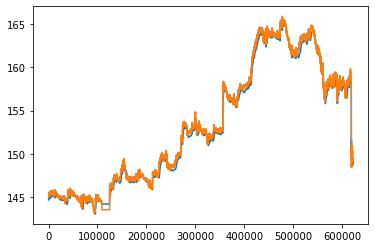

In [12]:
items_plot = test_data_y
plt.plot(list(range(len(preds))), preds)
plt.plot(list(range(len(items_plot))), items_plot)
axes = plt.gca()
#axes.set_ylim([145,170])
#axes.set_xlim([260000,261200])
#axes.set_xlim([100000,120000])
#axes.set_xlim([140000,160000])

#axes.set_xlim([540000,560000])
#axes.set_xlim([610000,660000])
plt.show()